# Eearning Per Share (EPS) forecasting with Neural Networks

In this notebook we explore application of Artificial Neural Networks to EPS prediction problem.

In this notebook we use fundamentals dataset built based on CRISP database. It includes, in particular, the following fields:

* __tic__	ticker name
* __datadate__	calendar date
* __EPS__  earnings per share (EPS)
* __EPS_t1__ lagged by one period EPS, i.e. $\text{EPS}_{t-1}$
* __EPS_t4__ lagged by four periods EPS, i.e. $\text{EPS}_{t-4}$
* __EPS_t5__ lagged by five periods EPS, i.e. $\text{EPS}_{t-5}$
* __INV_t1__ inventories lagged by one period, i.e. $\text{INV}_{t-1}$
* __AR_t1__	account receivables lagged by one period, i.e. $\text{AR}_{t-1}$
* __SA_t1__	adminstrative expenses lagged by one period, i.e. $\text{SA}_{t-1}$
* __GM_t1__	gross margin, defined as sales less cost of goods sold, lagged by one period, i.e. $\text{GM}_{t-1}$
* __CAPX_t1__ capital expenditues lagged by one period, i.e. $\text{CAPX}_{t-1}$
* __ETR_t1__ effective tax rate, defined as income taxes divided by pretax income, lagged by one period, i.e. $\text{CAPX}_{t-1}$

For details on the linear and non-linear models for EPS prediction, see W. Zhang et. al. "Neural Network Earnings per Share Forecasting Models: A Comparative Analysis of Alternative Methods" (2004)
https://pdfs.semanticscholar.org/140b/9ce9358978dc84f979062d79faa3e6fe7076.pdf

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import pandas as pd
import numpy as np

import os
from tensorflow.python.layers import core as core_layers

from mpl_toolkits.mplot3d import Axes3D

def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Get the data

In [2]:
df = pd.read_csv('./data/finratio/CRSP_EPS_SPX500_ALL_v3.csv')

EPS_predictors = ['EPS_t1', 'EPS_t2', 'EPS_t4', 'INV_t1', 'AR_t1', 'CAPX_t1', 'SA_t1', 'GM_t1']

other_predictors = ['epspxq', 'dlttq','dd1q', 'saleq', 'cogsq', 'xsgaq', 'prccq', 'ceqq', 'cshoq',
                   'cshoq', 'ibcomq', 'atq','ibq']

predictors = EPS_predictors + other_predictors

# from_dt = '2001-03-31'
# to_dt = '2002-06-30'

from_dt = '2001-01-02' # '2015-09-30'
to_dt = '2017-01-02' # '2016-03-31'

df = df.loc[(df['datadate'] >= from_dt) & (df['datadate'] <= to_dt), :]
df.loc[:, ['EPS']+ predictors].head()

,EPS,EPS_t1,EPS_t2,EPS_t4,INV_t1,AR_t1,CAPX_t1,SA_t1,GM_t1,epspxq,...,saleq,cogsq,xsgaq,prccq,ceqq,cshoq,cshoq,ibcomq,atq,ibq
89,0.009680,NaN,0.18,0.01,NaN,NaN,NaN,NaN,NaN,0.45,...,809.0,109.0,281.0,46.49,5264.0,232.783,232.783,105.0,9528.0,105.0
90,0.009604,0.45,NaN,-0.15,0.004062,0.007478,0.012463,0.025941,0.064622,0.47,...,821.0,109.0,301.0,48.94,4614.0,219.941,219.941,107.0,9710.0,107.0
91,0.013049,0.47,0.45,0.18,0.004159,0.006600,0.026400,0.027214,0.064374,0.52,...,833.0,105.0,292.0,39.85,4454.0,212.585,212.585,113.0,9655.0,113.0
92,0.011067,0.52,0.47,NaN,0.006129,0.008673,0.053426,0.033767,0.084187,0.45,...,846.0,113.0,297.0,40.66,4322.0,208.981,208.981,96.0,9913.0,96.0
93,0.009637,0.45,0.52,0.45,0.007693,0.011306,0.075881,0.034618,0.085439,0.39,...,839.0,113.0,298.0,40.47,3251.0,183.265,183.265,77.0,9875.0,77.0


In [3]:
# how many unique tickers are in the data
num_uniq_tics = df.tic.nunique()

print(df.shape, num_uniq_tics)

(38567, 124) 736


In [4]:
# only keep records with non-negative total assets
df = df[df.atq >= 0.01]

In [5]:
# how many nans 
for col in other_predictors:
    num_nans = np.sum(df[col].isnull()) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))

32 Nans in col epspxq
179 Nans in col dlttq
29861 Nans in col dd1q
32 Nans in col saleq
154 Nans in col cogsq
7739 Nans in col xsgaq
4 Nans in col prccq
86 Nans in col ceqq
51 Nans in col cshoq
51 Nans in col cshoq
27 Nans in col ibcomq
26 Nans in col ibq


In [6]:
#  for other predictors, replace nans by 0
df[other_predictors] = df[other_predictors].replace(to_replace={np.nan: 0.0})

In [7]:
for col in other_predictors:
    num_nans = np.sum(df[col].isnull()) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))
print('New shape of df: ', df.shape)

New shape of df:  (38474, 124)


In [8]:
# convert dates to datetypes
df['date'] = pd.to_datetime(df.datadate,errors='raise')

# Make a composite index 
df.set_index(['tic', 'date'], inplace=True)

In [9]:
# fill nans in other_predictors (not needed anymore?)
df[other_predictors] = df.groupby(level=0,group_keys=False)[other_predictors].fillna(method='bfill',limit=1).values

In [10]:
df['TD'] = df.dlttq + df.dd1q

# define financial ratio variables 
df['EBITDA'] = df.saleq  - df.cogsq - df.xsgaq   # EBITDA
df['Price_to_Book'] = df.prccq/(0.0001 + (df.ceqq/df.cshoq))
df['Price_to_Sales_per_shape'] = df.prccq/(0.0001 + (df.saleq/df.cshoq))
df['Gross_Profit_Margin'] = (df.saleq - df.cogsq)/(0.001 + df.saleq)
df['EBITDA_margin'] = df.EBITDA/(0.001 + df.saleq)
df['ROA'] = df.ibcomq/(0.001 + df.atq)   # atq is Total Assets
df['ROE'] = df.ibq/(0.001 + df.ceqq) 
df['Debt_to_Asset'] = df.TD/(0.001 + df.atq)
df['log_Size'] = np.log(1 + df.atq)


In [11]:
fin_ratios = ['epspxq', 'Price_to_Book','Price_to_Sales_per_shape', 'Gross_Profit_Margin',
             'EBITDA_margin', 'ROA', 'ROE', 'Debt_to_Asset','log_Size']


df[fin_ratios].describe()

,epspxq,Price_to_Book,Price_to_Sales_per_shape,Gross_Profit_Margin,EBITDA_margin,ROA,ROE,Debt_to_Asset,log_Size
count,38474.000000,3.846300e+04,3.847400e+04,38474.000000,38474.000000,38474.000000,3.847400e+04,38474.000000,38474.000000
mean,0.522737,7.763244e+02,3.740563e+02,-6.202179,-7.784245,0.011723,1.265652e+03,0.228381,9.084340
std,1.769719,2.014420e+04,1.581859e+04,1038.735204,1051.688974,0.040723,5.692861e+04,0.174143,1.543288
min,-75.120000,-5.840715e+03,-7.905681e+01,-195579.000000,-195579.000000,-3.854616,-3.927000e+06,0.000000,3.135190
25%,0.180000,1.554139e+00,3.220841e+00,0.243925,0.108395,0.003566,1.494893e-02,0.097261,8.031812
50%,0.460000,2.467847e+00,6.161902e+00,0.380764,0.188912,0.011793,3.390314e-02,0.204896,9.023938
75%,0.860000,4.055304e+00,1.139851e+01,0.562758,0.308758,0.022922,5.511394e-02,0.328086,10.057495
max,196.570000,1.161200e+06,2.058500e+06,13.691828,13.691828,0.885519,4.132200e+06,1.760481,15.007539


In [12]:
for col in fin_ratios:
    num_nans = np.sum(df[col].isnull()) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))

11 Nans in col Price_to_Book


In [13]:
df[fin_ratios] = df.groupby(level=0,group_keys=False)[fin_ratios].fillna(method='bfill',limit=2).values

In [14]:
# check that there are no more outliers in fin_ratios
for col in fin_ratios:
    num_nans = np.sum(df[col].isnull()) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))

3 Nans in col Price_to_Book


In [15]:
# drop these records
df = df[df.Price_to_Book.notnull()]

In [16]:
# predictors = EPS_predictors + fin_ratios
df[EPS_predictors] = df.groupby(level=0,group_keys=False)[EPS_predictors].fillna(method='bfill',limit=4).values


In [17]:
# check the result
for col in EPS_predictors:
    flag_nan = df[col].isnull()
    num_nans = np.sum(flag_nan) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))
        df.loc[flag_nan, col] = 0.0

24 Nans in col EPS_t1
6 Nans in col EPS_t2
4 Nans in col EPS_t4
586 Nans in col INV_t1
213 Nans in col AR_t1
428 Nans in col CAPX_t1
7388 Nans in col SA_t1
28 Nans in col GM_t1


/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [18]:
# replace remaining Nans by zeros in EPS_predictors
df[EPS_predictors] = df[EPS_predictors].replace(to_replace={np.nan: 0.0}, inplace=False)

for col in EPS_predictors:
    num_nans = np.sum(df[col].isnull()) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))

In [19]:
# A function that computes the following:
# Normalized past returns for the Q1, Q2, Q3, Q4 look-back periors
# Normalized future returns for the Q1, Q2, Q3, Q4 look-forward periors
# Normalized future EPS for the Q1, Q2, Q3, Q4 look-forward periors

def make_past_future_returns_and_EPS(x, eps=0.0001):
    # historical Q1, Q2, Q3 Q4 returns
    x["ret_Qm1"] = (np.log(eps+x["prccq"]) - np.log(eps+x["prccq"].shift(1))).fillna(method='bfill', limit=1)
    x["ret_Qm2"] = (np.log(eps+x["prccq"]) - np.log(eps+x["prccq"].shift(2))).fillna(method='bfill', limit=1)
    x["ret_Qm3"] = (np.log(eps+x["prccq"]) - np.log(eps+x["prccq"].shift(3))).fillna(method='bfill', limit=1)
    x["ret_Qm4"] = (np.log(eps+x["prccq"]) - np.log(eps+x["prccq"].shift(4))).fillna(method='bfill', limit=1)
    
    # normalize 
    for i in np.arange(1,5):
        col= 'ret_Qm'+str(i)
        x[col] = x[col].fillna(method='bfill', limit=4)
        x[col] = (x[col] - x[col].mean())/(eps + x[col].std())
    
    # future_returns, to be used as targets
    x["ret_Qp1"] = (np.log(eps+x["prccq"]).shift(-1) - 
                    np.log(eps+x["prccq"])).fillna(method='bfill', limit=1)
    x["ret_Qp2"] = (np.log(eps+x["prccq"]).shift(-2) - 
                    np.log(eps+x["prccq"])).fillna(method='bfill', limit=1)
    x["ret_Qp3"] = (np.log(eps+x["prccq"]).shift(-3) - 
                    np.log(eps+x["prccq"])).fillna(method='bfill', limit=1)
    x["ret_Qp4"] = (np.log(eps+x["prccq"]).shift(-4) - 
                    np.log(eps+x["prccq"])).fillna(method='bfill', limit=1)
    
    # normalize 
    for i in np.arange(1,5):
        col= 'ret_Qp'+str(i)
        x[col] = (x[col] - x[col].mean())/(eps + x[col].std())
        
    # Add future EPS
    x["EPS_Qp1"] = x["epspxq"].shift(-1).fillna(method='bfill', limit=1)
    x["EPS_Qp2"] = x["epspxq"].shift(-2).fillna(method='bfill', limit=1)
    x["EPS_Qp3"] = x["epspxq"].shift(-3).fillna(method='bfill', limit=1)
    x["EPS_Qp4"] = x["epspxq"].shift(-4).fillna(method='bfill', limit=1)
    
    # normalize 
    for i in np.arange(1,5):
        col= 'EPS_Qp'+str(i)
        x[col] = (x[col] - x[col].mean())/(eps + x[col].std())
         
    return x

In [20]:
# make all these additional columns
df = df.groupby(level=0, group_keys=False).apply(make_past_future_returns_and_EPS)

# all new columns
ret_Qm_cols = ['ret_Qm'+str(i) for i in np.arange(1,5)]
ret_Qp_cols = ['ret_Qp'+str(i) for i in np.arange(1,5)]
EPS_Qp_cols = ['EPS_Qp'+str(i) for i in np.arange(1,5)]

all_new_cols = ret_Qm_cols + ret_Qp_cols + EPS_Qp_cols

df[all_new_cols].describe()

,ret_Qm1,ret_Qm2,ret_Qm3,ret_Qm4,ret_Qp1,ret_Qp2,ret_Qp3,ret_Qp4,EPS_Qp1,EPS_Qp2,EPS_Qp3,EPS_Qp4
count,3.846800e+04,3.845000e+04,3.843500e+04,3.841900e+04,3.772600e+04,3.699700e+04,3.627400e+04,3.555400e+04,3.772600e+04,3.699700e+04,3.627400e+04,3.555400e+04
mean,3.290148e-19,-6.583377e-19,2.380184e-18,-7.513417e-19,1.259544e-18,-6.361794e-19,-4.162495e-19,2.248300e-18,3.037031e-18,3.240914e-18,-1.664998e-18,-2.598036e-18
std,9.897537e-01,9.900104e-01,9.901054e-01,9.900834e-01,9.898017e-01,9.898358e-01,9.897581e-01,9.896637e-01,9.901293e-01,9.900047e-01,9.898623e-01,9.897293e-01
min,-8.008766e+00,-7.862073e+00,-7.857845e+00,-7.852305e+00,-7.976574e+00,-7.734484e+00,-7.665686e+00,-7.595720e+00,-7.757975e+00,-7.699356e+00,-7.640310e+00,-7.580804e+00
25%,-4.226462e-01,-4.589377e-01,-4.895512e-01,-5.104064e-01,-4.225261e-01,-4.508372e-01,-4.873176e-01,-5.058463e-01,-4.377509e-01,-4.391280e-01,-4.404992e-01,-4.443838e-01
50%,7.838346e-02,1.045183e-01,1.051674e-01,1.042155e-01,7.668833e-02,1.057951e-01,1.076548e-01,1.072019e-01,5.272509e-02,5.148173e-02,5.154715e-02,4.900480e-02
75%,5.659650e-01,5.915390e-01,5.992350e-01,6.203592e-01,5.653095e-01,5.889142e-01,5.981912e-01,6.230491e-01,4.765666e-01,4.778111e-01,4.775303e-01,4.763114e-01
max,6.371407e+00,4.781074e+00,4.869120e+00,4.729155e+00,6.325269e+00,4.705349e+00,4.747951e+00,4.583756e+00,7.655840e+00,7.597929e+00,7.539292e+00,7.475591e+00


In [21]:
for col in all_new_cols:
    num_nans = np.sum(df[col].isnull()) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))

3 Nans in col ret_Qm1
21 Nans in col ret_Qm2
36 Nans in col ret_Qm3
52 Nans in col ret_Qm4
745 Nans in col ret_Qp1
1474 Nans in col ret_Qp2
2197 Nans in col ret_Qp3
2917 Nans in col ret_Qp4
745 Nans in col EPS_Qp1
1474 Nans in col EPS_Qp2
2197 Nans in col EPS_Qp3
2917 Nans in col EPS_Qp4


In [22]:
# remove all records that do not have all these values

df = df[df['ret_Qm4'].notnull()]
df = df[df['ret_Qp4'].notnull()]

In [23]:
for col in all_new_cols:
    num_nans = np.sum(df[col].isnull()) 
    if  num_nans > 0:
        print('%d Nans in col %s' % (num_nans, col))

In [24]:
## remove outliers in dependent variables

low_cut = 2  # in percents
high_cut = 98 


dependent_variables = ret_Qp_cols + EPS_Qp_cols

for col in dependent_variables:
    low_percentile = np.percentile(df[col], low_cut)
    high_percentile = np.percentile(df[col], high_cut)
    idx_low_val = np.logical_not(df[col] > low_percentile)
    idx_high_val = np.logical_not(df[col] < high_percentile)
    df.loc[idx_low_val, col] = low_percentile
    df.loc[idx_high_val, col] = high_percentile

df[dependent_variables].describe()


/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,ret_Qp1,ret_Qp2,ret_Qp3,ret_Qp4,EPS_Qp1,EPS_Qp2,EPS_Qp3,EPS_Qp4
count,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000
mean,0.000702,-0.002794,-0.001641,0.000702,0.000337,0.005384,0.012543,0.016691
std,0.891284,0.914055,0.930527,0.935071,0.790193,0.797521,0.803795,0.814724
min,-2.676308,-2.660726,-2.544398,-2.456912,-2.216741,-2.227797,-2.215068,-2.227142
25%,-0.429879,-0.458182,-0.490977,-0.505846,-0.444314,-0.442136,-0.440671,-0.444384
50%,0.074245,0.103094,0.105362,0.107202,0.042091,0.044860,0.048449,0.049005
75%,0.566646,0.586460,0.595853,0.623049,0.452651,0.462602,0.468883,0.476311
max,1.752849,1.767341,1.856395,1.833807,1.813354,1.839676,1.880109,1.928859


In [25]:
# Trim outliers in predictors 

low_cut = 2  # in percents
high_cut = 98 


fin_ratios = ['epspxq', 'Price_to_Book','Price_to_Sales_per_shape', 'Gross_Profit_Margin',
             'EBITDA_margin', 'ROA', 'ROE', 'Debt_to_Asset','log_Size']


predictors = ret_Qm_cols + fin_ratios

for col in predictors:
    low_percentile = np.percentile(df[col], low_cut)
    high_percentile = np.percentile(df[col], high_cut)
    print(col,low_percentile, high_percentile)
    idx_low_val = np.logical_not(df[col] > low_percentile)
    idx_high_val = np.logical_not(df[col] < high_percentile)
    df.loc[idx_low_val, col] = low_percentile
    df.loc[idx_high_val, col] = high_percentile

df[predictors].describe()

ret_Qm1 -2.69088495274 1.76401296792
ret_Qm2 -2.65406143737 1.77444418334
ret_Qm3 -2.56460310922 1.86557818164
ret_Qm4 -2.47335751171 1.87581892613
epspxq -1.42 2.67
Price_to_Book -1.01381061464 16.7280490642
Price_to_Sales_per_shape 0.591750889428 39.6957032567
Gross_Profit_Margin 0.0329325394075 0.897721404874
EBITDA_margin -0.16769427825 0.667184056426
ROA -0.0488030513569 0.0603347876004
ROE -0.25180058254 0.275802415686
Debt_to_Asset

/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


 0.0 0.647552384784
log_Size 6.08402713408 12.5813576137


,ret_Qm1,ret_Qm2,ret_Qm3,ret_Qm4,epspxq,Price_to_Book,Price_to_Sales_per_shape,Gross_Profit_Margin,EBITDA_margin,ROA,ROE,Debt_to_Asset,log_Size
count,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000
mean,0.000510,-0.006223,-0.001927,0.004021,0.543838,3.372144,8.897760,0.409929,0.216861,0.013265,0.033923,0.222136,9.056056
std,0.895081,0.921013,0.938545,0.944689,0.698326,3.136474,8.513063,0.219132,0.165334,0.018882,0.072571,0.164722,1.459104
min,-2.690885,-2.654061,-2.564603,-2.473358,-1.420000,-1.013811,0.591751,0.032933,-0.167694,-0.048803,-0.251801,0.000000,6.084027
25%,-0.428493,-0.470522,-0.497017,-0.510921,0.190000,1.554522,3.201173,0.242996,0.108075,0.003655,0.015242,0.094342,8.009565
50%,0.077494,0.101831,0.108060,0.113816,0.460000,2.458685,6.071460,0.379313,0.188213,0.011932,0.034178,0.200507,8.995141
75%,0.567755,0.592045,0.602688,0.629973,0.850000,4.026136,11.278074,0.560449,0.307717,0.023112,0.055076,0.323528,10.031341
max,1.764013,1.774444,1.865578,1.875819,2.670000,16.728049,39.695703,0.897721,0.667184,0.060335,0.275802,0.647552,12.581358


In [26]:
print(np.sum(df.EPS.isnull()))
print(np.sum(df.epspxq.isnull()))


30
0


In [27]:
# remove rows with Nans for epspxq
df = df[df.epspxq.notnull()]


In [28]:
print(np.sum(df.EPS.isnull()))

30


In [29]:
low_percentile=np.percentile(df["epspxq"], 2)
high_percentile=np.percentile(df["epspxq"], 98)

print(low_percentile, high_percentile)
# df = df[np.logical_and(df["EPS"] >= low_percentile, df["EPS"] <= high_percentile)]

-1.42 2.67


In [30]:
df['EPS'].describe()

count    35524.000000
mean        -0.001363
std          0.228308
min        -16.857143
25%          0.006506
50%          0.012540
75%          0.018355
max          4.922865
Name: EPS, dtype: float64

In [31]:
# get the names and industrial sectors for tickers
df_industry = pd.read_csv('./data/spx_components/industry_classification.csv', index_col=0)

In [32]:
df_industry.head()

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie,Health Care
ACN,Accenture plc,Information Technology
ATVI,Activision Blizzard,Information Technology


In [33]:
# add the name and sector info to the main data frame
df = df.reset_index().merge(df_industry.reset_index().rename(columns={"Symbol": "tic"}), on="tic", how="left")

In [34]:
# for tickers that did not find a matching sector, rename the sector to "Unknown"
df["Sector"].replace(np.nan, "Unknown", inplace=True)

In [35]:
# make a dictionary and inverse dictionary for industry sectors
sectors = dict(zip(df["Sector"].unique(), range(0, len(df["Sector"].unique()))))
sectors_inverse = dict(zip(range(0, len(df["Sector"].unique())), df["Sector"].unique()))

# add a column for the sector ID
df["sector_id"] = df["Sector"].apply(lambda x: sectors[x])

In [36]:
# check the statistics of stocks from different sectors

# put results in a small dataframe
df_sector_stats = pd.DataFrame(data=None,
                              columns=['Sector','Counts', 'Percent_counts'])

num_records = df.shape[0]

for sector,i in sectors.items():
#     print (i, sector)
    df_sector_stats.loc[i,'Counts'] = df[df.Sector==sector].shape[0]
    df_sector_stats.loc[i,'Sector'] = sector
    df_sector_stats.loc[i,'Percent_counts'] = (100.0/num_records) * df_sector_stats.loc[i,'Counts']
    
print('Total number of records = ', df.shape[0])

df_sector_stats

Total number of records =  35554


,Sector,Counts,Percent_counts
0,Unknown,11300,31.7826
1,Utilities,1433,4.03049
2,Telecommunications Services,240,0.67503
3,Health Care,2595,7.29876
4,Information Technology,2935,8.25505
5,Industrials,3161,8.8907
6,Consumer Discretionary,4449,12.5134
7,Consumer Staples,2208,6.21027
8,Real Estate,1530,4.30331
9,Financials,2906,8.17348


### Define the train and test datasets

In [37]:
# check for valid inputs
# predictors = ['EPS_t1','EPS_t2','EPS_t3', 'EPS_t4', 'INV_t1', 'AR_t1', 'CAPX_t1', 'GM_t1', 'SA_t1', 'ETR_t1']
predictors = ret_Qm_cols + fin_ratios

for col in predictors:
    print(col, np.sum(df[col].isnull()))

ret_Qm1 0
ret_Qm2 0
ret_Qm3 0
ret_Qm4 0
epspxq 0
Price_to_Book 0
Price_to_Sales_per_shape 0
Gross_Profit_Margin 0
EBITDA_margin 0
ROA 0
ROE 0
Debt_to_Asset 0
log_Size 0


In [38]:
df[predictors].describe()

,ret_Qm1,ret_Qm2,ret_Qm3,ret_Qm4,epspxq,Price_to_Book,Price_to_Sales_per_shape,Gross_Profit_Margin,EBITDA_margin,ROA,ROE,Debt_to_Asset,log_Size
count,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000,35554.000000
mean,0.000510,-0.006223,-0.001927,0.004021,0.543838,3.372144,8.897760,0.409929,0.216861,0.013265,0.033923,0.222136,9.056056
std,0.895081,0.921013,0.938545,0.944689,0.698326,3.136474,8.513063,0.219132,0.165334,0.018882,0.072571,0.164722,1.459104
min,-2.690885,-2.654061,-2.564603,-2.473358,-1.420000,-1.013811,0.591751,0.032933,-0.167694,-0.048803,-0.251801,0.000000,6.084027
25%,-0.428493,-0.470522,-0.497017,-0.510921,0.190000,1.554522,3.201173,0.242996,0.108075,0.003655,0.015242,0.094342,8.009565
50%,0.077494,0.101831,0.108060,0.113816,0.460000,2.458685,6.071460,0.379313,0.188213,0.011932,0.034178,0.200507,8.995141
75%,0.567755,0.592045,0.602688,0.629973,0.850000,4.026136,11.278074,0.560449,0.307717,0.023112,0.055076,0.323528,10.031341
max,1.764013,1.774444,1.865578,1.875819,2.670000,16.728049,39.695703,0.897721,0.667184,0.060335,0.275802,0.647552,12.581358


In [39]:
# one-fourth of the data with be used for a test set
test_size = len(df) // 4

# all outputs (predict the next-quarter return)
# Y = df["EPS"].values
Y = df.EPS_Qp1.values

# un-normalized inputs 
# X_raw = df[['EPS_t1','EPS_t2','EPS_t3','EPS_t4']].values
# Use the set of variables from M2 model, but add EPS_t2, EPS_t3
X_raw = df[predictors].values

# standardize inputs
X = (X_raw - np.mean(X_raw, axis=1, keepdims=True)) / (0.00000001 + np.std(X_raw, axis=1, keepdims=True))

# standardize the outputs
Y = (Y - np.mean(Y))/(0.001 + np.std(Y))

# sector ID values
X_sector = df["sector_id"].values

# randomly select a set of rows that will be used for a test
test_ids = np.random.randint(low=0, high=Y.shape[0], size=test_size)

# construct indices for the train set by excluding indices for the test set
train_ids =  np.arange(0, Y.shape[0])
train_ids = train_ids[np.logical_not(np.in1d(train_ids, test_ids))]

# make input datasets 
X_train = X[train_ids, :]
X_train_sectors = X_sector[train_ids] # for categorical "sector_id" values
Y_train = Y[train_ids]

# test datasets
X_test  = X[test_ids, :]
X_test_sectors = X_sector[test_ids]
Y_test  = Y[test_ids]

print (X_train.shape, X_train_sectors.shape, Y_train.shape, X_test.shape, X_test_sectors.shape, Y_test.shape)

(27660, 13) (27660,) (27660,) (8888, 13) (8888,) (8888,)


In [40]:
tf.__version__

'1.3.0'

## A Class for a Neural Network 

In [41]:
class Model:
    def __init__(self, n_input, n_output, hidden_layer_shapes=[32], 
                 activation=tf.nn.relu, optimizer = tf.train.GradientDescentOptimizer,
                num_sectors=len(sectors)):
        
        self.x = tf.placeholder(tf.float32, shape=(None, n_input), name="X")
        self.x_sectors = tf.placeholder(tf.int32, shape=(None), name="X_sectors")
        self.y = tf.placeholder(tf.float32, shape=(None, n_output), name="y")
        
        self.learning_rate = tf.placeholder(tf.float32, name="learning_rate")
        
        # dropout specification
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        
        # use a one-hot representation for sector ID values
        x_sectors_one_hot = tf.one_hot(self.x_sectors, num_sectors)
        
        # include the output layer in the list of layers
        hidden_layer_shapes_full = hidden_layer_shapes + [n_output]
        
        # add "one-hot" boolean sector variables to the data
        previous_layer_output = tf.concat([self.x, x_sectors_one_hot], axis=-1)
        
#         print ("previous_layer_output:", previous_layer_output)
        
        previous_layer_size = n_input + num_sectors
        
        # define all layers
        for i in range(0, len(hidden_layer_shapes_full)):
            if i < (len(hidden_layer_shapes_full) - 1):
                # inner (hidden) layer
                hidden_layer = core_layers.Dense(hidden_layer_shapes_full[i], activation=activation)   
            else:
                # output layer
                hidden_layer = core_layers.Dense(hidden_layer_shapes_full[i])
                
            hidden_layer.build([None, previous_layer_size])
            
            # output of a hidden layer is an iput to the next layer
            previous_layer_output = hidden_layer(previous_layer_output)
            
            # apply a dropout to hidden layers
            if i < (len(hidden_layer_shapes_full) - 1):
                previous_layer_output = tf.nn.dropout(previous_layer_output, keep_prob=self.keep_prob)   
            
            # also redefine the size of the previous layer as the size of the current layer 
            previous_layer_size = hidden_layer_shapes_full[i]
        
        # define other ops
        self.loss = tf.reduce_mean(tf.square(previous_layer_output - self.y))
        self.train_op = (optimizer(self.learning_rate).minimize(self.loss), self.loss)
        self.output = previous_layer_output

## Create a Neural Network model

In [42]:
model = Model(n_input=X.shape[1], n_output=1, hidden_layer_shapes=[32])

In [43]:
batch_size = 256
learning_rate = 0.05
n_iters = 50000
keep_prob = 0.2 # 1 - dropout rate

history = []

load_model_from_disk = False

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    if load_model_from_disk:
        try:
            saver.restore(sess, './feed_fwd_nn_eps.ckpt')
            print ("model loaded")
        except:
            print ("model not loaded")
        
    losses = []
    for i in range(0, n_iters):
        batch_ids = np.random.randint(low=0, high=Y_train.shape[0], size=batch_size).tolist()
        batch_x = X_train[batch_ids, :]
        batch_x_sectors = X_train_sectors[batch_ids]
        
        batch_y = Y_train[batch_ids]
        _, loss = sess.run(model.train_op, feed_dict={
            model.x: batch_x,
            model.x_sectors: batch_x_sectors,
            model.y: np.expand_dims(batch_y, -1),
            model.learning_rate: learning_rate,
            model.keep_prob: keep_prob
        })
        losses.append(loss)
        if len(losses) % 100 == 0:
            test_loss = sess.run(model.loss, feed_dict={
                model.x: X_test,
                model.x_sectors: X_test_sectors,
                model.y: np.expand_dims(Y_test, -1),
                model.keep_prob: 1.0
            })
            train_loss = sess.run(model.loss, feed_dict={
                model.x: X_train,
                model.x_sectors: X_train_sectors,
                model.y: np.expand_dims(Y_train, -1),
                model.keep_prob: 1.0
            })
            
            # print (np.mean(losses), train_loss, test_loss)
            history.append([np.mean(losses), train_loss, test_loss])
            losses = []
    save_path = saver.save(sess, './feed_fwd_nn_eps.ckpt')
    print('Saved session to %s' % save_path)

Saved session to ./feed_fwd_nn_eps.ckpt


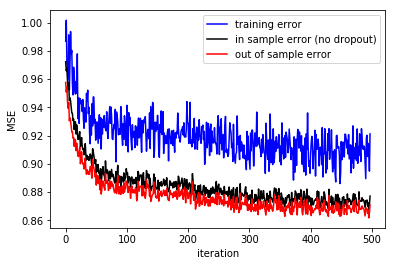

In [44]:
plt.figure()
history = np.array(history)
a, = plt.plot(history[2:,0], c="#0000FF", label="training error")
b, = plt.plot(history[2:,1], c="#000000", label="in sample error (no dropout)")
c, = plt.plot(history[2:,2], c="#ff0000", label="out of sample error")
plt.legend(handles=[a,b,c])
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.show()

In [50]:
# get predictions
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './feed_fwd_nn_eps.ckpt')
    predictions = sess.run(model.output, feed_dict={
                model.x: X_test,
                model.x_sectors: X_test_sectors,
                model.keep_prob: 1.0
            })

INFO:tensorflow:Restoring parameters from ./feed_fwd_nn_eps.ckpt


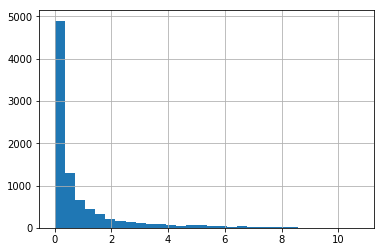

In [51]:
pairs = np.hstack([predictions, np.expand_dims(Y_test, -1)])
df_results = pd.DataFrame(pairs, columns=["predicted", "actual"])
df_results["squared error"] = np.square(df_results.predicted - df_results.actual)
df_results["squared error"].hist(bins=30)
plt.show()

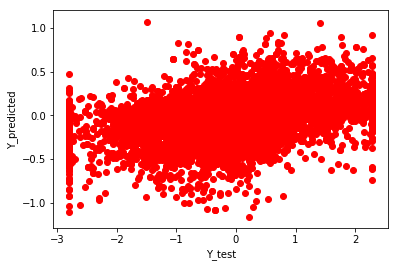

In [52]:
# Predicted vs actual Y-values
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
# ax.scatter(X_test[:,1], X_test[:,2], predictions, s=1, c="#FF0000")

Y_predicted = np.array(predictions)
plt.scatter(Y_test, Y_predicted, color='r')
plt.xlabel('Y_test')
plt.ylabel('Y_predicted')

plt.show()


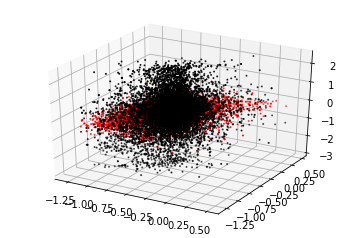

In [105]:
# 3D view of actual (black points) vs predicted values (in red)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
ax.scatter(X_test[:,1], X_test[:,2], predictions, s=1, c="#FF0000")
plt.show()


In [106]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [24]:
show_graph(tf.get_default_graph())